# Predicting the Number of Claps for Posts on Medium.com
### Advanced Data Analytics for Management Support
Sascha Geyer<br>
Chair of Information Systems<br>
School of Business and Economics<br>
Humboldt-University of Berlin<br>
sascha.geyer@hu-berlin.de<br>

### Table of Contents

* [1. Introduction](#chap1)
* [2. Numeric Data Analysis](#chap2)
    * [2.1 Data Preparation](#chap2_1)
    * [2.2 Explanatory Data Analysis](#chap2_2)
    * [2.3 Feature Engineering](#chap2_3)
    * [2.4 Model Selection and Evaluation](#chap2_4)
* [3. Natural Language Processing](#chap3)
    * [3.1 Text Preprocessing](#chap3_1)
    * [3.2 TFIDF-based Keyword Extraction](#chap3_2)
    * [3.3 Tokenization and Sequence Padding](#chap3_3)
    * [3.4 Deep Learning Model](#chap3_4)   
* [4. Predictions](#chap4)

# 1. Introduction <a class="anchor" id="chap1"></a>
This jupyter notebook aims at applying predictive analytics to estimate the number of claps a post on Medium.com will receive based on it's unstructured textual data as well as associated structured data. Due to this mixed character of data sources we split the predictive modeling process in two parts. The first part focuses solely on the structured data provided, following a classical regression problem. The second part will embrace natural language processing and deep learning in order to extract predictive power out of the unstructured textual data provided. We conclude by evaluating and comparing model performance to ultimately generate our test set predictions.

# 2. Numeric Data Analysis <a class="anchor" id="chap2"></a>
In this first part we handle all structured, i.e. numeric and categorical data in order to determine the best fitting regressor to predict our continous target variable based on normalized, numeric features. After elaborating on data preparation we conduct an explanatory data analysis to subsequently craft predictive features. Ultimately we evaluate five different regression estimators including a stacking model in order to determine our best-performing regression model.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

%matplotlib inline  
plt.rcParams["figure.figsize"] = (20,10)
seed = 123

## 2.1 Data Preparation <a class="anchor" id="chap2_1"></a>

In [2]:
try:
    train = pd.read_pickle('train.pkl')
except (OSError, IOError) as e:
    train = pd.read_csv("Train.csv", index_col=False, sep=',', encoding='utf-8')
    train.to_pickle('train.pkl')

test = pd.read_csv("Test.csv", index_col=0, sep=',', encoding='utf-8')

### Test Set Data Preparation
We start with the test set because it's variables determine which training set variables will be relevant for our analysis.
#### firstPublishedDate

In [3]:
# extract date from PublicationDetails as Regex
re_date = r'((Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s.*)'
extracted_date = test['PublicationDetails'].str.extract(re_date)[0]

# convert date string to datetime and coerce errors (NaT)
test['firstPublishedDate'] =  pd.to_datetime(extracted_date, format='%b %d, %Y', errors='coerce')

# remove date string from PublicationDetails
test.replace({'PublicationDetails': re_date}, {'PublicationDetails': ''}, regex=True, inplace=True)

#### publicationname

In [4]:
# extract publication name from PublicationDetails as Regex
re_publisher = r'(\sin\s)(.+)'
test['publicationname'] = test['PublicationDetails'].str.extract(re_publisher)[1]

# remove publication name from PublicationDetails, leaving only the name of the author
test.replace({'PublicationDetails': re_publisher}, {'PublicationDetails': ''}, regex=True, inplace=True)

#### author

In [5]:
# we drop the 'Author' variable because it is messy (mixed with dates)
test.drop('Author', axis=1, inplace=True)

# instead we use the author names provided in 'PublicationDetails' because they appear to have less flaws
test.rename(columns = {"PublicationDetails": "author"}, inplace = True)

#### responsesCreatedCount

In [6]:
# extract only digits from responses
test['responsesCreatedCount'] = test['Responses'].str.extract(r'(\d+)').astype('float32')
test.drop('Responses', axis=1, inplace=True)

#### wordCount

In [7]:
test['wordCount'] = test['Length'].astype('float32')
test.drop('Length', axis=1, inplace=True)

#### index

In [8]:
# we drop the needless index variable
test.drop('index', axis=1, inplace=True)

#### text, title

In [9]:
# fill missing Header values with empty string
test['Header'].fillna('', inplace=True)

# we include the title in the text just like in the training set
test['text'] = test['Header'] + ' ' + test['Text']

# we drop Header and Text
test.drop(['Header', 'Text'], axis=1, inplace=True)

### Training Set Data Preparation
Although the training set provides a multitude of variables, most of them prove to be useless for our analysis. This is the case for all variables that we don't find in the test set and can't recreate with the test set data. We considered recreating the features codeBlockCount, imageCount and linksCount by counting the occurences of corresponding html tags (e.g. '<img' or '<a') in the articles' text strings. However, comparing our text feature to web scraped data we find that the vast majority of articles in the data is missing the according html snippets, thus making it impossible to count code blocks, images or links in the test set. Therefore we carefully chose all relevant features which either show up in the test set or are believed to serve for subsequent feature enginnering such as 'scrappedDate', 'usersFollowedByCount' and 'usersFollowedCount'.

In [10]:
relevant_features = [
    'text',
    'language',
    'author',
    'responsesCreatedCount',
    'wordCount',
    'firstPublishedDate',
    'publicationname',
    'scrappedDate',
    'usersFollowedByCount',
    'usersFollowedCount',
    'postId',
    'totalClapCount'
]

train = train[relevant_features]

Inspecting the data we realize that articles are duplicated for every tag name they have assigned. Thus, for now we will drop these duplicates since we don't need them for our non-textual data preparation. We use the postId variable to drop all duplicated articles.

In [11]:
# drop duplicates based on postId
train = train.drop_duplicates(subset='postId')

# drop postId
train.drop('postId', axis=1, inplace=True)

#### Numeric Features

In [12]:
num_features_train = [
    'responsesCreatedCount',
    'wordCount',
    'totalClapCount',
    'usersFollowedByCount',
    'usersFollowedCount'
]

train[num_features_train] = train[num_features_train].astype(np.float32)

#### firstPublishedDate

In [13]:
train['firstPublishedDate'] = pd.to_datetime(train['firstPublishedDate'], errors='coerce')

#### scrappedDate

In [14]:
train['scrappedDate'] =  pd.to_datetime(train['scrappedDate'], format='%Y%m%d', errors='coerce')

#### publicationname
Comparing the training set feature 'publicationname' to the test set feature 'puplicationname' which we extracted from 'PublicationDetails', we came across a naming dissimilarity. While the training set uses the publisher name 'Hacker Noon', the test notation is 'HackerNoon.com'. At this point we considered the usage of fuzzywuzzy, a fuzzy string matching library (https://github.com/seatgeek/fuzzywuzzy). However, further examination of the provided data suggested that we found an isolated case and there is no significant amount of naming inconsistencies that justify the usage of fuzzywuzzy. Given the amount of 21 articles in the test set affected by this irregularity, we approve to conduct a single manual correction to match the notation used in the training set.

In [15]:
# comparing publication names in test and training set
print(test['publicationname'].value_counts()[:10].sort_values(ascending=False))
print(train['publicationname'].value_counts()[:10].sort_values(ascending=False))

# manually fix notation dissimilarity
test.loc[test['publicationname'] == 'HackerNoon.com', 'publicationname'] = 'Hacker Noon'

Netflix TechBlog        175
TE-FOOD                  34
The Startup              24
HackerNoon.com           21
freeCodeCamp.org         15
One Table, One World      9
60 Months to Ironman      6
The Billfold              5
The Establishment         4
The Lily                  4
Name: publicationname, dtype: int64
Towards Data Science                                                      3836
Hacker Noon                                                               1253
Becoming Human: Artificial Intelligence Magazine                           758
Data Driven Investor                                                       659
Chatbots Life                                                              479
SyncedReview                                                               367
Chatbots Magazine                                                          359
The Startup                                                                317
Planeta Chatbot : todo sobre los Chatbots y la Intel

#### Store text-related data for subsequent NLP analysis

In [16]:
nlp_relevant_features_train = ['text', 'language', 'wordCount', 'totalClapCount']
nlp_relevant_features_test = ['text', 'wordCount']

nlp_train = train[nlp_relevant_features_train].copy()
nlp_test = test[nlp_relevant_features_test].copy()

# we don't need the nlp features for now
train.drop(['text', 'language'], axis=1, inplace=True)
test.drop('text', axis=1, inplace=True)

## 2.2 Explanatory Data Analysis <a class="anchor" id="chap2_2"></a>


### Missing Values

In [17]:
print(train.isnull().sum().sort_values(ascending = False))
print(test.isnull().sum().sort_values(ascending = False))

publicationname          38707
totalClapCount               0
usersFollowedCount           0
usersFollowedByCount         0
scrappedDate                 0
firstPublishedDate           0
wordCount                    0
responsesCreatedCount        0
author                       0
dtype: int64
publicationname          94
responsesCreatedCount    82
firstPublishedDate       71
wordCount                 0
author                    0
dtype: int64


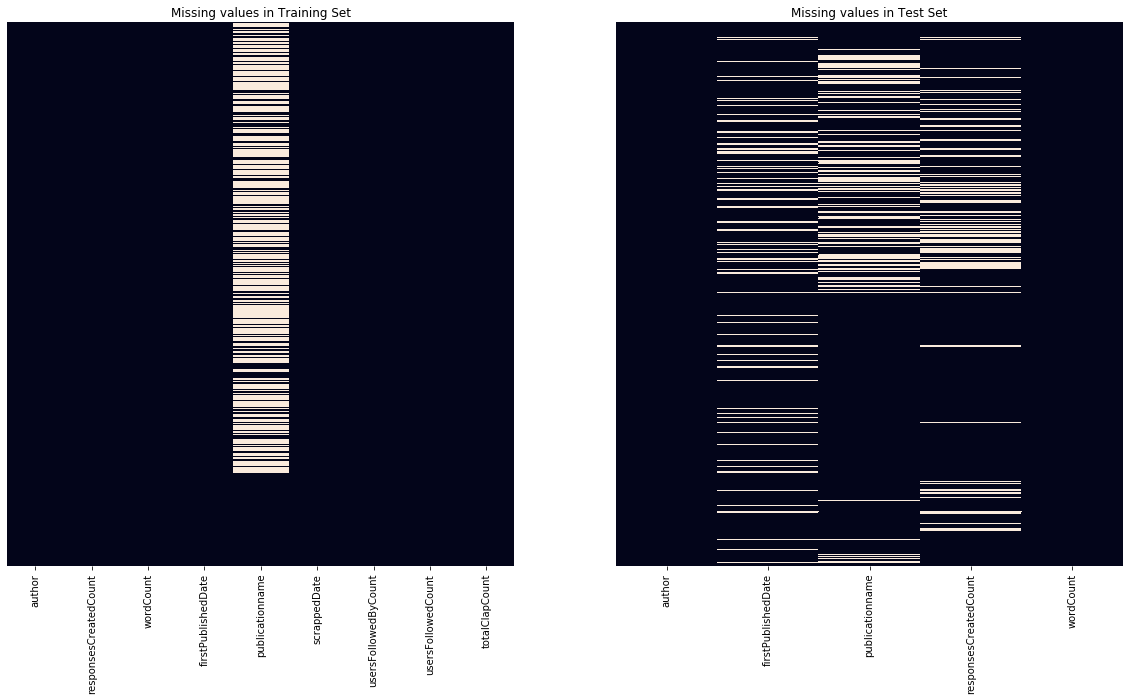

In [18]:
fig, axs = plt.subplots(ncols=2)
sns.heatmap(train.isnull(), cbar=False, yticklabels=False, ax=axs[0]).set_title("Missing values in Training Set");
sns.heatmap(test.isnull(), cbar=False, yticklabels=False, ax=axs[1]).set_title("Missing values in Test Set");

### Feature Correlaction

We haven't dealt with distribution and outlier handling yet but the correlation matrix already reveals that the amount of responses an article receives is the feature with by far highest correlation to our target 'totalClapCount'. 

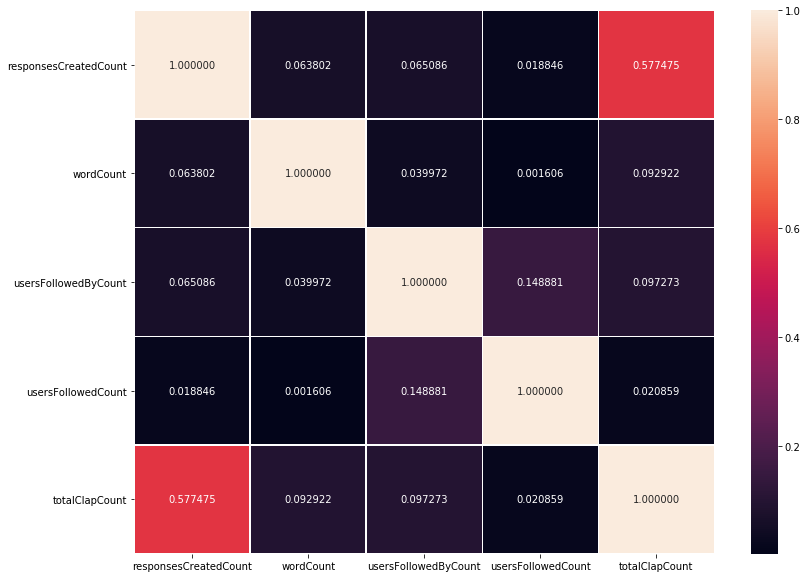

In [19]:
f,ax = plt.subplots(figsize=(13, 10))
sns.heatmap(train.corr(), annot=True, linewidth=.5, fmt='1f');

### Data Overlap between Train and Test Set
We check the relationship between train and test set to later augment the test data with associated data from the training set where appropriate.
#### author

In [20]:
auhtors_unique = test['author'].nunique()
authors_known = test['author'].isin(train['author']).sum()
print('There are {} unique authors in the test set.'.format(auhtors_unique))  
print('{} of {} articles have authors that we know form the training set.'.format(authors_known, len(test)))  

There are 214 unique authors in the test set.
283 of 514 articles have authors that we know form the training set.


#### publicationname

In [21]:
publications_unique = test['publicationname'].nunique()
publications_nan = test['publicationname'].isna().sum()
publications_known = test['publicationname'].isin(train['publicationname']).sum() - publications_nan
print('There are {} unique publication names in the test set.'.format(publications_unique))  
print('{} of {} articles have publication names that we know form the training set.'.format(publications_known, len(test)))  

There are 100 unique publication names in the test set.
318 of 514 articles have publication names that we know form the training set.


### Univariate Distribution of Numeric Variables
#### Boxplots

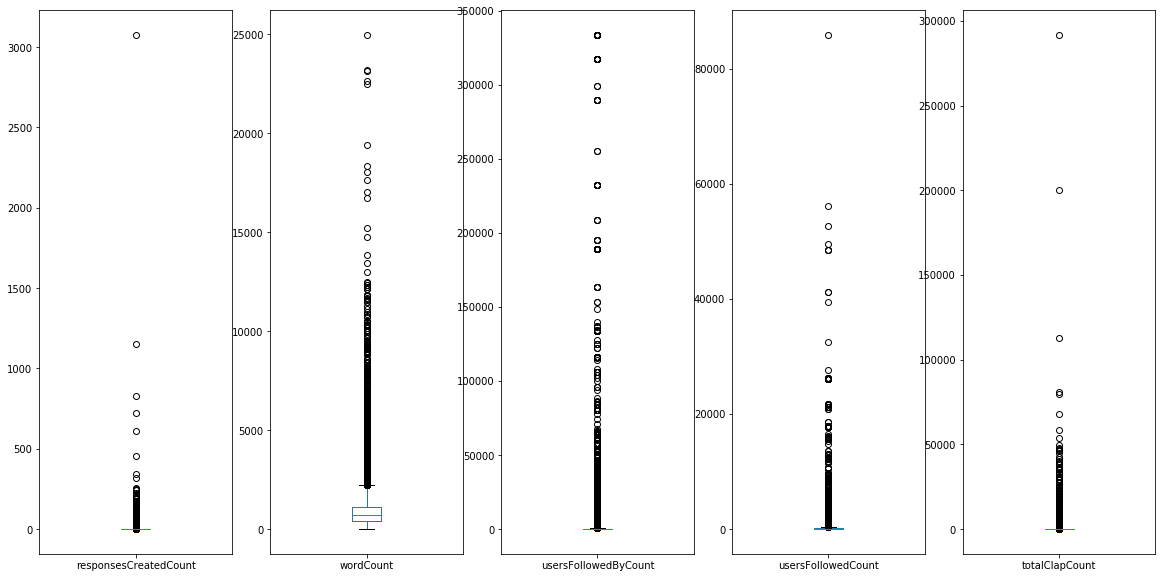

In [22]:
num_features = [x for x in train.columns if train[x].dtype == 'float32']
num_data = train[num_features]
num_data.plot(kind = 'box', subplots=True);

#### Outlier Truncation
We will truncate outliers, but the feature 'responsesCreatedCount' has a distribution, we will treat later seperately

In [23]:
# outlier truncation function (copied from ADAMS Tutorial by Stefan Lessmann)
def outlier_truncation(x, factor=1.5):
    x_new = x.copy()
    
    IQR = x.quantile(0.75) - x.quantile(0.25) 
    
    upper = x.quantile(0.75) + factor*IQR
    lower = x.quantile(0.25) - factor*IQR
    
    x_new[x < lower] = lower
    x_new[x > upper] = upper
    
    return x_new

# truncate all numeric features except for responsesCreatedCount and totalClapCount
ignore = ['responsesCreatedCount', 'totalClapCount']
truncate_features = [feature for feature in num_features if feature not in ignore]
train[truncate_features] = train[truncate_features].apply(outlier_truncation)

#### Test Set Missing Value Imputation
To avoid data leakage we impute missing values in the test set by calculating the median in the training set.

In [24]:
# impute missing values in 'responsesCreatedCount' with training set median
responsesCreatedCount_median = train['responsesCreatedCount'].median()
test['responsesCreatedCount'].fillna(responsesCreatedCount_median, inplace=True)

## 2.3 Feature Engineering <a class="anchor" id="chap2_3"></a>
Since we need to craft features for both the training and test set, we will concatenate both data sets to edit them jointly and afterwards split them up again into test and train.

In [25]:
# Concatenate test and train set using 'test' and 'train' keys
data = pd.concat([test, train], keys=['test', 'train'])

#### responsesCreatedCount
The feature 'responsesCreatedCount' has a distribution which could potentially be hard for an algorithm to pick up on generalizable patterns. Therefore we evaluated different approaches to transform this variable to a different type or scale. Our first attempt was discretizing the continuous feature into a categorical feature 'responsesCat'. By label-encoding the responses into 6 categories: 0, 1, 2, 3, 4, 5, 6+. However a better performing approach turned out to be transforming the variable to a logarithmic scale.

In [26]:
# log transformation performes better than discretization
data.loc[data['responsesCreatedCount'] == 0, 'responsesCreatedCount'] = 0.01
data['responsesCreatedCount'] = np.log(data['responsesCreatedCount'])

# also tested discretization by applying 6 levels with label encoding 
#data['responsesCat'] = np.where(data['responsesCreatedCount'] > 5 , 6, data['responsesCreatedCount'])

#### usersFollowedByCount
We add the followers count to test set authors that we already know from the training set.

In [27]:
data['usersFollowedByCount'] = data.groupby('author')['usersFollowedByCount'].transform('mean')
data['usersFollowedByCount'].fillna((data['usersFollowedByCount'].median()), inplace=True) #try mean

#### usersFollowedCount
We add the following count to test set authors that we already know from the training set.

In [28]:
data['usersFollowedCount'] = data.groupby('author')['usersFollowedByCount'].transform('mean')
data['usersFollowedCount'].fillna((data['usersFollowedCount'].median()), inplace=True) #try mean

#### publicationClapsMean
We add a feature for average claps per publisher.

In [29]:
data['publicationClapsMean'] = data.groupby('publicationname')['totalClapCount'].transform('mean').astype('float32')
data['publicationClapsMean'].fillna((data['totalClapCount'].median()), inplace=True) # try mean
data.drop('publicationname', axis=1, inplace=True)

#### authorClapsMean
We add a feature for average claps per author.

In [30]:
# --- create feature for average claps per author
data['authorClapsMean'] = data.groupby('author')['totalClapCount'].transform('mean').astype('float32')
data['authorClapsMean'].fillna((data['totalClapCount'].median()), inplace=True) # try mean
data.drop('author', axis=1, inplace=True)

#### daysElapsed
We create a new feature 'daysElapsed' by calculating the difference between the date of data scraping ('scrappedDate') and the date of publication ('firstPublishedDate'). Looking into the data we find test set articles that were published after the training set scraping date. This suggests that data scraping for the test set must have happened later in time. In order to approximate a date, we calculate the time difference between the training set scraping date (2018-11-04) and the most recent article published in the training set (2018-09-30). This time delta (35 days) is then added to the pulication date of the most recent test set article (2018-12-28) to come up with an estimated scraping date (2019-02-01) for the test set. 
Apart from time distance we could also check for seasonal effects, examining wether articles get more claps in specific time intervals, such as months or days of the week.

In [31]:
# calculate estimated scraping date for test set
train_scrape_date = data.loc['train', 'scrappedDate'][0]
train_last_published_date = data.loc['train', 'firstPublishedDate'].max()
timedelta = train_scrape_date - train_last_published_date
test_last_published_date = data.loc['test', 'firstPublishedDate'].max()
test_scrape_date_estimator = test_last_published_date + timedelta

# set estimated scraping date for test set
data.loc['test', 'scrappedDate'] = test_scrape_date_estimator

# calculate new feature 'daysElapsed' and fill missing values with median
data['daysElapsed'] = (data['scrappedDate'] - data['firstPublishedDate']).dt.days.astype('float32')
data['daysElapsed'].fillna((data.loc['test', 'daysElapsed'].median()), inplace=True)


# drop 'scrappedDate' and 'firstPublishedDate'
data.drop('scrappedDate', axis=1, inplace=True)
data.drop('firstPublishedDate', axis=1, inplace=True)

## 2.4 Model Selection and Evaluation <a class="anchor" id="chap2_4"></a>
### Data Normalization
we normalize all the data except for the target. Especially required for multi-layer perceptron (neural network).

In [32]:
def normalize (col):
    return (col-col.mean())/col.std()

normalize_features = [feature for feature in data.columns if data[feature].dtype == 'float32' and data[feature].name != 'totalClapCount']

data[normalize_features] = data[normalize_features].apply(normalize)

### Train Test Split

In [33]:
# Split data again into train and test set using the corresponding keys
# we need to copy() the dataframe because of hidden chaining -> settingwithcopywarning (https://www.dataquest.io/blog/settingwithcopywarning/)
train = data.loc['train'].copy()
test = data.loc['test'].copy()
test.drop('totalClapCount', axis=1, inplace=True)

# 'y' is our target and 'X' our features
y = train.pop('totalClapCount')
X = train

### Repeated K-Fold Cross Validation
To validate the performance of our models we use repeated k-fold cross validation to calculate an avereged root mean squarred error.

In [34]:
from sklearn.model_selection import RepeatedKFold, cross_val_score

splits = 6
cv_scoring = ('neg_root_mean_squared_error')

### Linear Regression

In [36]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm_rkf = RepeatedKFold(n_splits = splits, n_repeats = 100, random_state = seed)
lm_scores = cross_val_score(lm, X, y, cv = lm_rkf, scoring = cv_scoring)
lm_avg_rmse = np.mean(lm_scores)
print('Linear Regression: average root mean squarred error for {} folds is {}'.format(splits, lm_avg_rmse))

Linear Regression: average root mean squarred error for 6 folds is -1053.3161010435401


### Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    max_depth = 30,
    n_estimators = 200,
    min_samples_split = 10,
    random_state = seed, 
    verbose = 1
)

rf_rkf = RepeatedKFold(n_splits = splits, n_repeats = 1, random_state = seed)
rf_scores = cross_val_score(rf_model, X, y, cv = rf_rkf, scoring = cv_scoring)
rf_avg_rmse = np.mean(rf_scores)
print('Random Forest: average root mean squarred error for {} folds is {}'.format(splits, rf_avg_rmse))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   42.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   41.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   40.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Random Forest: average root mean squarred error for 6 folds is -1138.9291044656095


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished


### XGBoost

In [42]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    learning_rate = 0.05,
    max_depth = 10,
    min_child_weight = 1,
    subsample = .1,
    colsample_bytree = .8,
    verbosity = 1
)

xgb_rkf = RepeatedKFold(n_splits = splits, n_repeats = 10, random_state = seed)
xgb_scores = cross_val_score(xgb_model, X, y, cv = xgb_rkf, scoring = cv_scoring)
xgb_avg_rmse = np.mean(xgb_scores)
print('XGBoost: average root mean squarred error for {} folds is {}'.format(splits, xgb_avg_rmse))

XGBoost: average root mean squarred error for 6 folds is -995.1817372639974


### Multi-Layer Perceptron Regressor (Mini Neural Network)

In [43]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(hidden_layer_sizes=(16, 64, 64), max_iter = 200, random_state = seed)

mlp_rkf = RepeatedKFold(n_splits = splits, n_repeats = 1, random_state = seed)
mlp_scores = cross_val_score(mlp_model, X, y, cv = mlp_rkf, scoring = cv_scoring)
mlp_avg_rmse = np.mean(mlp_scores)
print('Multi-Layer Perceptron: average root mean squarred error for {} folds is {}'.format(splits, mlp_avg_rmse))

Multi-Layer Perceptron: average root mean squarred error for 6 folds is -1053.1403481540574


### Stacking Model

In [41]:
from sklearn.ensemble import StackingRegressor

estimators = [
    ('lm', lm),
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('mlp', mlp_model)
]

stacking_model = StackingRegressor(estimators = estimators)
stacking_model_rkf = RepeatedKFold(n_splits = splits, n_repeats = 1, random_state = seed)
stacking_model_scores = cross_val_score(stacking_model, X, y, cv = stacking_model_rkf, scoring = cv_scoring)
stacking_model_avg_rmse = np.mean(stacking_model_scores)
print('Stacking Model: average root mean squarred error for {} folds is {}'.format(splits, stacking_model_avg_rmse))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   39.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   32.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   31.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   30.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   33.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   31.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   31.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   32.6s finished
[Parallel(n_jobs=1)]: Us

Stacking Model: average root mean squarred error for 6 folds is -1066.1827143282812


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished


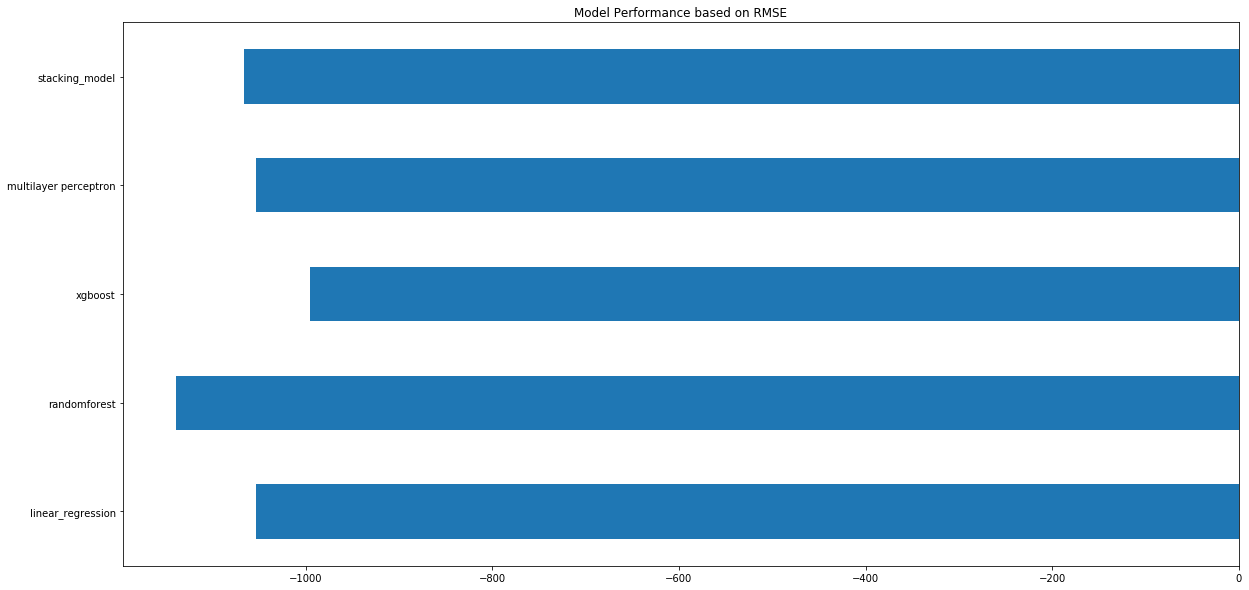

In [44]:
rmse_list = pd.Series({
    'linear_regression': lm_avg_rmse,
    'randomforest': rf_avg_rmse,
    'xgboost': xgb_avg_rmse,
    'multilayer perceptron': mlp_avg_rmse,
    'stacking_model': stacking_model_avg_rmse}).plot(kind = 'barh', title='Model Performance based on RMSE')

XGBoost outperformes our stacked model, so we use this as numeric estimator. It is the only model that scored an RMSE below 1000. Let's evaluate feature importance for this model.

In [45]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= seed)

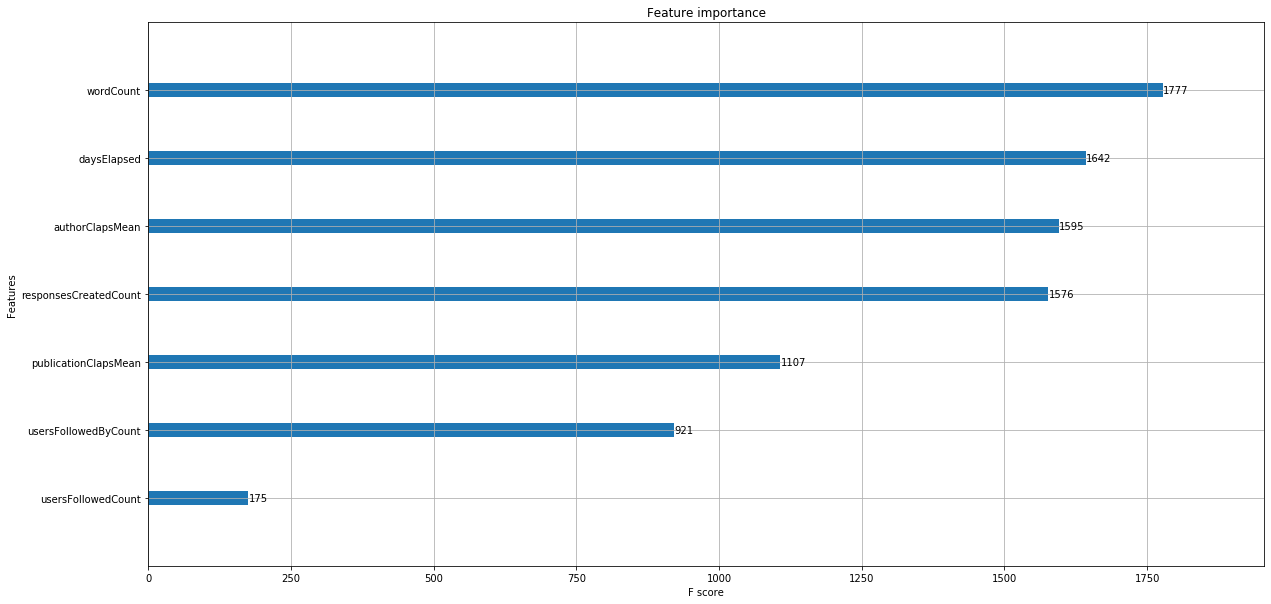

In [46]:
# fit XGBoost and make predictions
xgb_model.fit(X_train, y_train)

# plot feature importance for XGBoost
xgb.plot_importance(xgb_model)
plt.show()

#  3. Natural Language Processing <a class="anchor" id="chap3"></a>
Having worked on predictive analytics for numeric data, we now shift to textual data and natural language processing. In order to predict the number of claps a post received, we will firstly implement a nlp pipeline using spaCy to preprocess the texts and subsequently feed the output of our pipeline into a deep learning model using Keras. So let's get started!

## 3.1 Text Preprocessing <a class="anchor" id="chap3_1"></a>
### Choosing spaCy over NLTK

After conducting some research on nlp libraries and frameworks, we decided to choose spaCy over NLTK as our primary nlp tool to work on textual data. spaCy is relatively new (2015) library, providing state-of-the-art text processing and additional functionality such as pretrained statistical models and deep learning integration. spaCy's API and documentation make it very easy to process text in any way. In our opinion, basic nlp tasks like stopword removal, pos tagging and lemmatization are implemented in a smarter way than in NLTK.

### NLP Data Preparation
In the first instance of our NLP analysis we will restrict the modeling process to predominant and meaningful text data. Thus, we filter out the minority of texts that are shorter than 400 words or not written in English language.

In [35]:
print(nlp_train.wordCount.describe())
print(nlp_train['language'].value_counts()[:10].sort_values(ascending=False))

count    72337.000000
mean       901.517273
std        863.260437
min          0.000000
25%        402.000000
50%        703.000000
75%       1138.000000
max      24964.000000
Name: wordCount, dtype: float64
en         66380
es           890
zh-Hant      880
pt           873
fr           551
tr           378
th           350
ru           347
ja           334
it           218
Name: language, dtype: int64


In [36]:
messy_data = nlp_train

# choose only english texts
nlp_train = nlp_train[nlp_train['language'] == 'en']

# choose only texts with decent length (to avoid excessive paddings with zeros)
nlp_train = nlp_train[nlp_train['wordCount'] > 400]

nlp_y = nlp_train['totalClapCount']
nlp_X = nlp_train['text']

nlp_y.reset_index(inplace=True, drop=True)
nlp_X.reset_index(inplace=True, drop=True)

print('NLP training sample texts: {}'.format(len(nlp_X)))
print('NLP training sample targets: {}'.format(len(nlp_y)))

NLP training sample texts: 50932
NLP training sample targets: 50932


In [37]:
# If you don't have spaCy installed: https://spacy.io/usage
import spacy
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

### Regular Expressions
Exploring the textual data we realize that a lot of pre-cleaning is required in order to remove html, non-alphabetic and single characters as well as optimize spacings. Therefore we setup a series of regular expressions to preprocess all documents in a first step.

In [38]:
regex = {
    # remove html tags
    'html': re.compile(r'<[^>]+>'),
    
    # remove non-alphabetic characters
    'non_alpha': re.compile('[^a-zA-Z]'),
    
    # custom regex to add a space between sticking words (e.g. 'endStart')
    'camel_case_space': re.compile('([a-z])([A-Z])'),
    
    # custom regex to remove single characters (also at beginning)
    'single_char': re.compile(r'(\s|^).(?=\s+)'),
    
    # regex to remove multiple spaces
    'multi_space': re.compile(r'\s\s+')
}

### Lemmatization and Stopword Removal
With spaCy lemmatizing text and removing stopwords is pretty straight forward. We make sure to skip pronouns which lemmatize '-PRON-' as well.<br>Fun fact: spaCy disposes of 305 stopwords, while NLTK just has 153 ;)

In [39]:
def lemmatize_and_remove_stopwords(text):
    doc = nlp(text)
    return ' '.join(token.lemma_ for token in doc if token.lemma_ != '-PRON-' and token.lemma_ not in stopwords)

### NLP Pipeline
To generate a corpus of lemmatized documents we feed our text data through a nlp pipeline that applies our regular expressions, performes lemmatization and removes stopwords.

In [40]:
def pass_nlp_pipeline(messy_texts):
    lemmatized_texts = []
    
    for messy_text in messy_texts:
        
        text = regex['html'].sub(' ', messy_text)
        text = regex['non_alpha'].sub(' ', text)
        text = regex['camel_case_space'].sub(r'\1 \2', text)
        text = regex['single_char'].sub(' ', text)
        text = regex['multi_space'].sub(' ', text)
        text = lemmatize_and_remove_stopwords(text.lower())
        lemmatized_texts.append(text)
        
    return lemmatized_texts

If there alrealdy exists an associated pickle, we load the lemma corpus from there. Otherwise we create the lemma corpus and save it as a pickle.

In [41]:
try:
    lemma_corpus = pd.read_pickle('lemma_corpus.pkl')
except (OSError, IOError) as e:
    lemma_corpus = pass_nlp_pipeline(nlp_X)
    pd.to_pickle(lemma_corpus, "lemma_corpus.pkl")

## 3.2 TFIDF-based Keyword Extraction <a class="anchor" id="chap3_2"></a>
To enable our model to characterize texts it is important to emphasize representative words in each document and reduce the number of tokens to a processable dimension. Apart from removing global stopwords there are two more steps we will consinder in order to select only the most characteristic tokens for every document. The first step is to remove corpus-specific stopwords which appear in the majority of corpus documents (we choose 85% as threshold). The second step is TF-IDF-based keyword extraction. TF-IDF stands for 'term frequency - inverse document frequency' and is a statistical measure which reflects the importance of a word in the context of it's document and the underlying corpus. Applying these preporcessing steps we reduce all documents to their 150 most representative keywords.

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# create a vocabulary of words and remove corpus-specific stopwords that appear in 85% of documents
vectorizer = CountVectorizer(max_df = 0.85)

# convert documents to a matrix of token counts
token_count_matrix = vectorizer.fit_transform(lemma_corpus)
feature_names = vectorizer.get_feature_names()

# transform our count matrix to a normalized tf-idf representation
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(token_count_matrix)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [44]:
def getTopKeywords(doc, top_n):
    # generate tf-idf for the given document
    tf_idf_vector = tfidf_transformer.transform(vectorizer.transform([doc]))
    keywords = pd.DataFrame(tf_idf_vector[0].T.todense(), index = feature_names, columns=["tfidf"])
    return keywords.sort_values(by = ["tfidf"], ascending = False)[:top_n].index.tolist()

If there alrealdy exists an associated pickle, we load the keyword corpus from there. Otherwise we create the keyword corpus and save it as a pickle.

In [45]:
try:
    keyword_corpus = pd.read_pickle('keyword_corpus.pkl')
except (OSError, IOError) as e:
    keyword_corpus = [getTopKeywords(doc, 150) for doc in lemma_corpus]
    pd.to_pickle(keyword_corpus, "keyword_corpus.pkl")

##  3.3 Tokenization and Sequence Padding <a class="anchor" id="chap3_3"></a>
We restrict the vocabulary size to the 3000 most popular words. Since the parameter 'num_words' in Keras' Tokenizer does not actually remove words from the word_index, we take care of removing all words with higher index than 3000. Subsequently we use the tokenizer to convert our lemma strings to numeric index sequences and add padding (by default at the beginning) where necessary.

In [56]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# vocabulary size limit
num_words = 3000

tokenizer = Tokenizer()
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(keyword_corpus)
tokenizer.word_index = {e:i for e, i in tokenizer.word_index.items() if i <= num_words}

# we need to add one for the out of bag word representation which by default is zero
VOCAB_SIZE = len(tokenizer.word_index) + 1

index_sequences = tokenizer.texts_to_sequences(keyword_corpus)
padded_sequences = pad_sequences(index_sequences)

## 3.4 Deep Learning Model <a class="anchor" id="chap3_4"></a>
### Train-Test-Split

In [47]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, nlp_y, test_size = 0.2, random_state = seed)

### Min-Max-Scaling
We will scale our target for model training and afterwards rescale to interpret errors (RMSE) and predictions.

In [48]:
from sklearn.preprocessing import MinMaxScaler

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

scaler = MinMaxScaler()
scaler.fit(y_train_reshaped)

scaled_y_train = scaler.transform(y_train_reshaped)
scaled_y_test = scaler.transform(y_test_reshaped)

### GloVe Embeddings
Instead of training embeddings ourselves we make use of pre-trained GloVe embeddings. The reason we apply this step is to capture semantic relationships between words more efficiently. For example the words 'blockain', 'crpyto' and 'bitcoin' should be vectorized in a way that reflects their semantic relationship. 
<br>In a first step we save the 100-dimensional GloVe Embeddings as a dictionary, where every word is assigned with an associated word vector.

In [49]:
embeddings_index = {}
with open('glove.6B/glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

We create an embedding matrix which maps every word in our vocabulary (word_index) to it's associated GloVe word vector (embedding_index). Out of vocabulary words will be zeros. Therefore, when specifying our vocabulary size we need to add one to the word index for the out of vocabulary word representation.


In [50]:
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Recurrent Neural Network
We use the KERAS API to setup a recurrent neural network. More specifically, we choose a bidirectional LSTM with 64 hidden units and a dense layer with linear activation function to output our continous target. To prevent overfitting on the training data, we take care of regularization by inserting two dropout layers and setting up a early stopping callback function. For this regression task we choose the mean squarred error as our loss and go with the default adam optimizer.

In [51]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

def build_nn():
    model = Sequential()
    model.add(Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        weights = [embedding_matrix],
        input_length = 148,
        trainable = False))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units = 16, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn_model = KerasRegressor(build_fn = build_nn, epochs = 8, batch_size = 64, validation_split = 0.2, verbose = True)

### Model Evaluation

In [52]:
early_stopper = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
nn_rkf = RepeatedKFold(n_splits = 3, n_repeats = 1, random_state = seed)
nn_scores = cross_val_score(nn_model, X_train, scaled_y_train, cv = nn_rkf, scoring = cv_scoring, fit_params={'callbacks': [early_stopper]})
nn_avg_rmse = np.mean(nn_scores)

# we need to rescale the rmse using the scaler from before
nn_avg_rmse_rescaled = scaler.inverse_transform([[nn_avg_rmse]])
print('Neural Network: average root mean squarred error for {} folds is {}'.format(3, nn_avg_rmse_rescaled[0][0]))


Train on 21730 samples, validate on 5433 samples
Epoch 1/8
21730/21730 [==============================] - 103s 5ms/step - loss: 0.0046 - val_loss: 7.7120e-05
Epoch 2/8
21730/21730 [==============================] - 110s 5ms/step - loss: 1.2345e-04 - val_loss: 5.1252e-05
Epoch 3/8
21730/21730 [==============================] - 96s 4ms/step - loss: 9.5212e-05 - val_loss: 3.4943e-05
Epoch 4/8
21730/21730 [==============================] - 97s 4ms/step - loss: 8.9464e-05 - val_loss: 3.3917e-05
Epoch 5/8
21730/21730 [==============================] - 98s 5ms/step - loss: 9.2647e-05 - val_loss: 3.7166e-05
Epoch 6/8
21730/21730 [==============================] - 98s 5ms/step - loss: 9.0735e-05 - val_loss: 3.2921e-05
Epoch 7/8
21730/21730 [==============================] - 99s 5ms/step - loss: 8.7572e-05 - val_loss: 1.0185e-04
Epoch 8/8
13582/13582 [==============================] - 19s 1ms/step
Train on 21730 samples, validate on 5433 samples
Epoch 1/8
21730/21730 [==========================

Apparently, our LSTM does not perform as well on the textual data as our benchmark XGBoost model did on the numeric data. This can be due to multiple reasons:
- the provided textual data does not carry enough target-related meaning: while numeric variables like 'amount of responses' strongly correlate with our target, the textual data might simply not expose as much significant information
- the data preprocessing was not suitable: there might be more convenient approaches to summarize and vectorize documents than our TF-IDF scoring approach. One alternative example is doc2vec, an unsupervised algorithm to convert documents into vector representations.
- the model does not fit the problem: while text classification problems like sentiment analysis are commonly tackled with recurrent neural networks which capture long-term dependencies, a deep learning model might not have been the best choice for our regression task. Alternatively, a topic modeling approach could be advisable. Promising NLP models which should be considered for future research inlcude Latent Dirichlet allocation and latent semantic analysis.
- the model hyperparameters need optimization: we could further search for optimal model parameters by applying grid search (sklearn.model_selection.GridSearchCV) in order to improve our model performance

# 4. Predictions <a class="anchor" id="chap4"></a>
In a final step we generate our predictions for the test set. Since our XGBoost model outperformed every other estimator including a stacking model of regressors and our nlp-driven recurrent neural network (LSTM), we stick to our evaluated XGBoost model to make predictions on the test set. Therefore we fit our model on all available numeric data and generate predictions for the test set. In a last step, we make sure to transform negative predictions to zero, since the model was not able to pick up on this limitation (just like all other models). Ultimately we save our predictions as a .csv file to disk.

In [55]:
# fit XGBoost model on all available data
xgb_model.fit(X, y)

# make predictions for the test set and truncate negative values
xgb_predictions = xgb_model.predict(test)
xgb_predictions[xgb_predictions < 0] = 0

# save predictions as .csv to disk
pred_df = pd.DataFrame({'Claps': xgb_predictions})
pred_df.to_csv('predictions_546266.csv', index_label='index', float_format = '%.6f')